# Water mass transformation code
Written by Elizabeth Maroon and Alice DuVivier

To calculate the WMT due to any other single process, read in any diag that contributes a freshwater flux, heat flux, or salt flux. It should be possible to fully decompose SHF and SFWF into different contributors. 

varsneeded for freshwater part => ['SFWF', 'EVAP_F', 'PREC_F', 'IOFF_F', 'SNOW_F', 'ROFF_F', 'SALT_F', 'MELT_F']   
varsneeded for heat part => ['SHF', 'QFLUX', 'LWDN_F', 'LWUP_F', 'SENH_F', 'SHF_QSW', 'MELTH_F'] 

Freshwater fluxes get treated the same as SFWF, while heat fluxes get treated the same as SHF. Salt fluxes (brine rejection and frazil) need to be scaled to a practical salinity and then get multiplied by beta to convert them to a surface density flux.  

NOTE: Think about any other possible sources of transformation not included above. Estuary Box Model? Robert filter? Subscale grid mixing?

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec

In [2]:
#choose cases and data paths
case1 = 'b.e21.B1850.f09_g17.CMIP6-piControl.001b'
case2 = 'b.e21.B1850.f09_g17.CMIP6-piControl.001_bl99b'
label1 = 'MUSHY'
label2 = 'BL99'

data_dir1 = '/glade/campaign/cgd/ppc/dbailey/'+case1+'/ocn/proc/tseries/month_1/'
data_dir2 = '/glade/campaign/cgd/ppc/dbailey/'+case2+'/ocn/proc/tseries/month_1/'

#to calculate surface density sigma_2
varsneeded = ['SALT', 'TEMP'] 
#vars needed for FW pieces
varsneeded = varsneeded + ['SFWF', 'EVAP_F', 'PREC_F', 'IOFF_F', 'SNOW_F', 'ROFF_F', 'SALT_F', 'MELT_F']   
#and vars needed for heat pieces
varsneeded = varsneeded + ['SHF', 'QFLUX', 'LWDN_F', 'LWUP_F', 'SENH_F', 'SHF_QSW', 'MELTH_F']  

In [3]:
%%time
#reading in files
ds1 = []
ds2 = []
for varname in varsneeded:
    print("loading "+varname)   
    # This loop takes a long time
    my_files=sorted(glob.glob(data_dir1+case1+'.pop.h.'+varname+'.*.nc'))[-2:]
    ds1.append(xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal'))
    my_files=sorted(glob.glob(data_dir2+case2+'.pop.h.'+varname+'.*.nc'))[-2:]
    ds2.append(xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal'))
    
    # TEST WITH SINGLE FILE OPENING
    #ds1.append(xr.open_dataset(data_dir1+case1+'.pop.h.'+varname+'.092101-097012.nc'))
    #ds2.append(xr.open_dataset(data_dir2+case2+'.pop.h.'+varname+'.092101-097012.nc'))

print("Merging files now")
ds1=xr.merge(ds1,compat='override')
ds2=xr.merge(ds2,compat='override')

loading SALT
loading TEMP
loading SFWF
loading EVAP_F
loading PREC_F
loading IOFF_F
loading SNOW_F
loading ROFF_F
loading SALT_F
loading MELT_F
loading SHF
loading QFLUX
loading LWDN_F
loading LWUP_F
loading SENH_F
loading SHF_QSW
loading MELTH_F
Merging files now
CPU times: user 5.15 s, sys: 306 ms, total: 5.45 s
Wall time: 11.5 s


## Just coastal points for WMT

In [4]:
# Load in coastal mask
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/DATA/masks/antarctic_ocean_masks_2.nc')
my_mask = ds_masks['coast_mask']

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sh_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'socn_mask' has multiple fill values {0, -2147483647}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'Wed_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'Ross_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  de

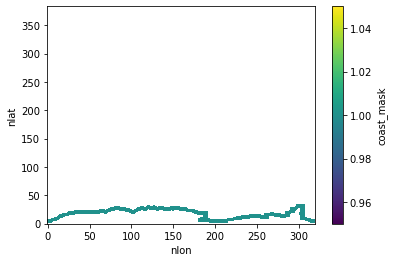

In [5]:
my_mask.plot()

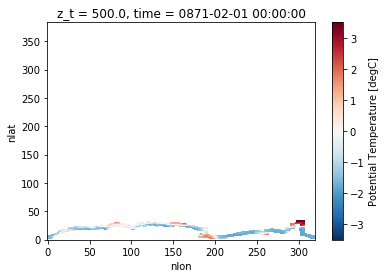

In [6]:
#region to perform WMT over - coastal mask only 
ds1=ds1.isel(z_t=0).where(my_mask==1)
ds2=ds2.isel(z_t=0).where(my_mask==1)

#test that masking worked properly
ds1["TEMP"].isel(time=0).plot()

In [7]:
%%time
# Takes ~8 min
ds1.load(); 
ds2.load();

CPU times: user 8min 20s, sys: 6min 2s, total: 14min 23s
Wall time: 19min 57s


<xarray.Dataset>
Dimensions:                 (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 1200, transport_comp: 5, transport_reg: 2, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
    z_t                     float32 500.0
  * z_t_150m                (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                     (z_w) float32 0.0 1000.0 ... 500004.7 525000.94
  * z_w_top                 (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
  * z_w_bot                 (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * lat_aux_grid            (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                   (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
    ULONG                   (nlat, nlon) float64 321.1 322.3 ... 319.6 320.0
    ULAT                    (nlat, nlon) float64 -78.95 -78.95 ... 72.41 72.41
    TLONG                   (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
    TLAT                    (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
  * time                    (time) object 0871-02-01 00:00:00 ... 0971-01-01 ...
Dimensions without coordinates: d2, moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables:
    moc_components          (time, moc_comp, nlat, nlon) object nan nan ... nan
    transport_components    (time, transport_comp, nlat, nlon) object nan ......
    transport_regions       (time, transport_reg, nlat, nlon) object nan ... nan
    dz                      (time, nlat, nlon) float32 nan nan nan ... nan nan
    dzw                     (time, z_w, nlat, nlon) float32 nan nan ... nan nan
    KMT                     (time, nlat, nlon) float64 nan nan nan ... nan nan
    KMU                     (time, nlat, nlon) float64 nan nan nan ... nan nan
    REGION_MASK             (time, nlat, nlon) float64 nan nan nan ... nan nan
    UAREA                   (time, nlat, nlon) float64 nan nan nan ... nan nan
    TAREA                   (time, nlat, nlon) float64 nan nan nan ... nan nan
    HU                      (time, nlat, nlon) float64 nan nan nan ... nan nan
    HT                      (time, nlat, nlon) float64 nan nan nan ... nan nan
    DXU                     (time, nlat, nlon) float64 nan nan nan ... nan nan
    DYU                     (time, nlat, nlon) float64 nan nan nan ... nan nan
    DXT                     (time, nlat, nlon) float64 nan nan nan ... nan nan
    DYT                     (time, nlat, nlon) float64 nan nan nan ... nan nan
    HTN                     (time, nlat, nlon) float64 nan nan nan ... nan nan
    HTE                     (time, nlat, nlon) float64 nan nan nan ... nan nan
    HUS                     (time, nlat, nlon) float64 nan nan nan ... nan nan
    HUW                     (time, nlat, nlon) float64 nan nan nan ... nan nan
    ANGLE                   (time, nlat, nlon) float64 nan nan nan ... nan nan
    ANGLET                  (time, nlat, nlon) float64 nan nan nan ... nan nan
    days_in_norm_year       (time, nlat, nlon) timedelta64[ns] NaT NaT ... NaT
    grav                    (time, nlat, nlon) float64 nan nan nan ... nan nan
    omega                   (time, nlat, nlon) float64 nan nan nan ... nan nan
    radius                  (time, nlat, nlon) float64 nan nan nan ... nan nan
    cp_sw                   (time, nlat, nlon) float64 nan nan nan ... nan nan
    sound                   (time, nlat, nlon) float64 nan nan nan ... nan nan
    vonkar                  (time, nlat, nlon) float64 nan nan nan ... nan nan
    cp_air                  (time, nlat, nlon) float64 nan nan nan ... nan nan
    rho_air                 (time, nlat, nlon) float64 nan nan nan ... nan nan
    rho_sw                  (time, nlat, nlon) float64 nan nan nan ... nan nan
    rho_fw                  (time, nlat, nlon) float64 nan nan nan ... nan nan
    stefan_boltzmann        (time, nlat, nlon) float64 nan nan nan ... nan nan
    latent_heat_vapor       (time, nlat, nlon) float64 nan nan nan ...

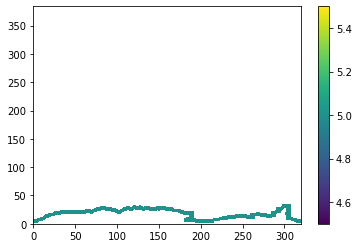

In [8]:
# set some values
s0=ds1['ocn_ref_salinity']
s0 = s0[0]
cp=ds1['cp_sw'].values/10000  #from erg/g/K -> J/kgK
cp = cp[0]
fusion=ds1['latent_heat_fusion'].values/10000 #from erg/g -> J/kg
fusion = fusion[0]

# get grid information
tlat=ds1['TLAT']
tlon=ds1['TLONG']
tarea=ds1['TAREA']/(100*100)  # convert to m2
depth=ds1['z_t']
ht=ds1['HT']
depth_top=depth.where(depth<ht, np.nan)/100

# make a quick plot of the area the WMT is done over
plt.pcolormesh(depth_top.isel(time=0))
plt.colorbar()

### Load Data from CASE1

In [9]:
## CASE1
#had to add loads to get everything on head node b/c eos method not working with dask
salt1=ds1['SALT'].load() 
temp1=ds1['TEMP'].load()

#get stuff from POP eqn of state (EOS), note that we're now refferencing pressure array to 2000m (i.e. sigma_2)
press_arr = xr.DataArray(2000*np.ones(depth_top.shape),dims=depth_top.dims, coords=depth_top.coords)
rho1,drhods1,drhodt1=pop_tools.eos(salt=salt1,temp=temp1,return_coefs=True,pressure=press_arr)

#construct alpha and beta using POP methods
alpha1=-1*drhodt1/rho1
beta1=drhods1/rho1

In [10]:
#adjusting SHF to make for total heat part, adding QFLUX, then dividing by cp dw
shf_scaled1 = (ds1['SHF']+ds1['QFLUX'])/cp

#adjusting FW to remove the frazil part, then multiplying to turn FW flux into salinity flux
fw_scaled1 = (ds1['SFWF'] - ds1['QFLUX']/fusion)*(salt1/1000)/(1-salt1/1000)

In [11]:
#multiply by alpha and beta to get density fluxes
heatpart1=-alpha1*shf_scaled1
fwpart1=-1*fw_scaled1*beta1

#combine to get total boundary forced density flux
densflux1=heatpart1+fwpart1

In [12]:
#Calculate components of the FW part

#salt flux (brine rejection) part
#needs to be scaled from kg salt to a FW flux
#then it can be multiplied by beta to convert to a surface density flux
salinity_factor1 = ds1['salinity_factor']
sflux_factor1 = ds1['sflux_factor']            
salt_f_fixed1 = ds1['SALT_F']*sflux_factor1/salinity_factor1   #doesn't need to be multiplied by -1 b/c -1 in salinity_factor
saltpart1 = -1*beta1*salt_f_fixed1 *(salt1/1000)/(1-salt1/1000)  

#freshwater flux from qflux (frazil) part
qflux_fw_fixed1 = -1*ds1['QFLUX']/fusion    #releasing heat of fusion = positive ocean heating = removal of FW -> multiply by -1 
frazilpart1=-1*beta1*qflux_fw_fixed1*(salt1/1000)/(1-salt1/1000)

#These are FW fluxes
#evaporation part  
evappart1 = -1*beta1*(ds1['EVAP_F']*(salt1/1000)/(1-salt1/1000))

#ice melt part
meltpart1 = -1*beta1*(ds1['MELT_F']*(salt1/1000)/(1-salt1/1000))

#precip part
precippart1 = -1*beta1*(ds1['PREC_F']*(salt1/1000)/(1-salt1/1000))

#runoff part - sum of liquid and solid runoff
runoffpart1 = -1*beta1*((ds1['ROFF_F']+ds1['IOFF_F'])*(salt1/1000)/(1-salt1/1000))

#total salt reconstructed
fwpart_recons1 = saltpart1+frazilpart1+evappart1+meltpart1+precippart1+runoffpart1

In [13]:
# heat components - not going to get into these because heat flux is so much smaller than FW fluxes

##to get latent heat flux, need to convert EVAP_F from FW flux to heat flux via latent heat of vaporization
#vaporization = ds['latent_heat_vapor']

#latent_heat = ds['EVAP_F']*vaporization
##can now be multiplied by alpha to convert to a surf dens flux

##snow melt needs to be converted from a FW flux to a heat flux via latent heat of fusion
#snow_melt_heating = ds['SNOW_F']*fusion*-1
##Multiplied by negative one b/c melt (positive) leads to cooling (negative)
##can now be multiplied by alpha to convert to a surf dens flux

##same goes for ice melt runoff (solid)
#ioff_heating = ds['IOFF_F']*fusion*-1

### Load Data from CASE2

In [14]:
## CASE2
#had to add loads b/c eos method not working with dask
salt2=ds2['SALT'].load()
temp2=ds2['TEMP'].load()
depth_top.load()

#get stuff from POP EOS
# note that we already defined the pressure=press_arr to reference 2000 m above, when loading case 1
rho2,drhods2,drhodt2=pop_tools.eos(salt=salt2,temp=temp2,return_coefs=True, pressure=press_arr)

#construct alpha and beta using POP methods
alpha2=-1*drhodt2/rho2
beta2=drhods2/rho2

In [15]:
#adjusting SHF to make for total heat part, adding QFLUX, then dividing by cp dw
shf_scaled2 = (ds2['SHF']+ds2['QFLUX'])/cp

#adjusting FW to remove the frazil part, then multiplying to turn salt flux into FW flux
fw_scaled2 = (ds2['SFWF'] - ds2['QFLUX']/fusion)*(salt2/1000)/(1-salt2/1000)

In [16]:
#multiply by alpha and beta to get density fluxes
heatpart2=-alpha2*shf_scaled2
fwpart2=-1*fw_scaled2*beta2

#combine to get total boundary forced density flux
densflux2=heatpart2+fwpart2

In [17]:
#Calculate components of the freshwater flux

#salt flux (brine rejection) part
#needs to be scaled from kg salt to a practical salinity
#then it can be multiplied by beta to convert to a surface density flux
salinity_factor2 = ds2['salinity_factor']
sflux_factor2 = ds2['sflux_factor']            
salt_f_fixed2 = ds2['SALT_F']*sflux_factor2/salinity_factor2           #doesn't need to be multiplied by -1 b/c -1 in salinity_factor
saltpart2=-1*beta2*salt_f_fixed2*(salt2/1000)/(1-salt2/1000)  

#freshwater flux from qflux (frazil) part
qflux_fw_fixed2 = -1*ds2['QFLUX']/fusion                               #releasing heat of fusion = positive ocean heating = removal of FW -> multiply by -1 
frazilpart2= -1*beta2*qflux_fw_fixed2*(salt2/1000)/(1-salt2/1000)

#These are FW fluxes
#evaporation part
evappart2 = -1*beta2*(ds2['EVAP_F']*(salt2/1000)/(1-salt2/1000))

#ice melt part
meltpart2 = -1*beta2*(ds2['MELT_F']*(salt2/1000)/(1-salt2/1000))

#precip part
precippart2 = -1*beta2*(ds2['PREC_F']*(salt2/1000)/(1-salt2/1000))

#runoff part - sum of liquid and solid runoff
runoffpart2 = -1*beta2*((ds2['ROFF_F']+ds2['IOFF_F'])*(salt2/1000)/(1-salt2/1000))

#total salt reconstructed
fwpart_recons2 = saltpart2+frazilpart2+evappart2+meltpart2+precippart2+runoffpart2

### Calculate WMT

In [18]:
#function for WMT 
def wmtrans(oneflux,dens_class,rho):
    binsize = dens_class[2]-dens_class[1]
    #assumes uniform density class spacing
    wmt=[]
    for ii in range(len(dens_class[0:-1])):
        densf_byclass = oneflux.where((rho>=dens_class[ii]) & (rho<dens_class[ii+1]),np.nan)
        wmt.append((densf_byclass*tarea).sum(['nlat','nlon'])/binsize)
    wmt = xr.concat(wmt, dim = sigma)
    return wmt
    
#set up density classes
binsize = 0.1 #typical value used
dens_class = np.arange(np.floor(rho1.min()),np.ceil(rho1.max()),binsize)
sigma = xr.DataArray(dens_class[0:-1]+binsize/2-1000, dims=['sigma'], coords={'sigma':dens_class[0:-1]+binsize/2-1000})


In [19]:
%%time
# Takes ~7 min
# CASE1
#calculate the WMT
wmt1 = wmtrans(densflux1, dens_class, rho1).load()
wmt1_heat = wmtrans(heatpart1, dens_class, rho1).load()
wmt1_fresh = wmtrans(fwpart1, dens_class, rho1).load()
#added loads to make plotting be faster later

#calculate WMF from WMT   
wmf1 = - wmt1.diff('sigma')#/binsize
wmf1 = wmf1.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_fresh = - wmt1_fresh.diff('sigma')#/binsize
wmf1_fresh = wmf1_fresh.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_heat = - wmt1_heat.diff('sigma')#/binsize
wmf1_heat = wmf1_heat.assign_coords({'sigma':sigma[0:-1]+binsize/2})

#got rid of division by binsize to keep units = to Sv and to follow Abernathey convention

CPU times: user 2min 42s, sys: 4min 5s, total: 6min 47s
Wall time: 6min 48s


In [20]:
%%time
# Takes ~7 min
# CASE2
#calculate the WMT
wmt2 = wmtrans(densflux2, dens_class, rho2).load()
wmt2_heat = wmtrans(heatpart2, dens_class, rho2).load()
wmt2_fresh = wmtrans(fwpart2, dens_class, rho2).load()
# calculate WMF from WMT  
wmf2 = - wmt2.diff('sigma')#/binsize
wmf2 = wmf2.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_fresh = - wmt2_fresh.diff('sigma')#/binsize
wmf2_fresh = wmf2_fresh.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_heat = - wmt2_heat.diff('sigma')#/binsize
wmf2_heat = wmf2_heat.assign_coords({'sigma':sigma[0:-1]+binsize/2})

#got rid of division by binsize to keep units = to Sv and to follow Abernathey convention

CPU times: user 2min 44s, sys: 4min 12s, total: 6min 57s
Wall time: 6min 57s


### Calculate WMT - individual FW terms

In [21]:
%%time
# ~20min
# CASE1 - FW terms
#calculate the WMT
wmt1_salt = wmtrans(saltpart1, dens_class, rho1).load()
wmt1_frazil = wmtrans(frazilpart1, dens_class, rho1).load()
wmt1_evap = wmtrans(evappart1, dens_class, rho1).load()
wmt1_melt = wmtrans(meltpart1, dens_class, rho1).load()
wmt1_precip = wmtrans(precippart1, dens_class, rho1).load()
wmt1_runoff = wmtrans(runoffpart1, dens_class, rho1).load()
wmt1_recons = wmtrans(fwpart_recons1, dens_class, rho1).load()

#calculate WMF from WMT   
wmf1_salt = - wmt1_salt.diff('sigma')#/binsize
wmf1_salt = wmf1_salt.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_frazil = - wmt1_frazil.diff('sigma')#/binsize
wmf1_frazil = wmf1_frazil.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_evap = - wmt1_evap.diff('sigma')#/binsize
wmf1_evap = wmf1_evap.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_precip = - wmt1_precip.diff('sigma')#/binsize
wmf1_precip = wmf1_precip.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_runoff = - wmt1_runoff.diff('sigma')#/binsize
wmf1_runoff = wmf1_runoff.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_melt = - wmt1_melt.diff('sigma')#/binsize
wmf1_melt = wmf1_melt.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_recons = - wmt1_recons.diff('sigma')#/binsize
wmf1_recons = wmf1_recons.assign_coords({'sigma':sigma[0:-1]+binsize/2})

#loaded WMTs and got rid of division by binsize for WMF

CPU times: user 6min 27s, sys: 10min 9s, total: 16min 36s
Wall time: 16min 46s


In [22]:
%%time
# ~20min
# CASE2 - FW terms
#calculate the WMT
wmt2_salt = wmtrans(saltpart2, dens_class, rho2).load()
wmt2_frazil = wmtrans(frazilpart2, dens_class, rho2).load()
wmt2_evap = wmtrans(evappart2, dens_class, rho2).load()
wmt2_melt = wmtrans(meltpart2, dens_class, rho2).load()
wmt2_precip = wmtrans(precippart2, dens_class, rho2).load()
wmt2_runoff = wmtrans(runoffpart2, dens_class, rho2).load()
wmt2_recons = wmtrans(fwpart_recons2, dens_class, rho2).load()

#calculate WMF from WMT   
wmf2_salt = - wmt2_salt.diff('sigma')#/binsize
wmf2_salt = wmf2_salt.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_frazil = - wmt2_frazil.diff('sigma')#/binsize
wmf2_frazil = wmf2_frazil.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_evap = - wmt2_evap.diff('sigma')#/binsize
wmf2_evap = wmf2_evap.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_precip = - wmt2_precip.diff('sigma')#/binsize
wmf2_precip = wmf2_precip.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_runoff = - wmt2_runoff.diff('sigma')#/binsize
wmf2_runoff = wmf2_runoff.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_melt = - wmt2_melt.diff('sigma')#/binsize
wmf2_melt = wmf2_melt.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_recons = - wmt2_recons.diff('sigma')#/binsize
wmf2_recons = wmf2_recons.assign_coords({'sigma':sigma[0:-1]+binsize/2})

#loading WMTs and not dividing by binsize

CPU times: user 6min 28s, sys: 10min 14s, total: 16min 43s
Wall time: 16min 53s


### Calculate means and differences

In [23]:
# Get annual mean WMT values 
# CASE1
wmt1_ann = wmt1.mean(dim="time")
wmf1_ann = wmf1.mean(dim="time")
wmt1_fresh_ann = wmt1_fresh.mean(dim="time")
wmf1_fresh_ann = wmf1_fresh.mean(dim="time")
wmt1_heat_ann = wmt1_heat.mean(dim="time")
wmf1_heat_ann = wmf1_heat.mean(dim="time")
wmt1_salt_ann = wmt1_salt.mean(dim="time")
wmf1_salt_ann = wmf1_salt.mean(dim="time")
wmt1_frazil_ann = wmt1_frazil.mean(dim="time")
wmf1_frazil_ann = wmf1_frazil.mean(dim="time")
wmt1_evap_ann = wmt1_evap.mean(dim="time")
wmf1_evap_ann = wmf1_evap.mean(dim="time")
wmt1_precip_ann = wmt1_precip.mean(dim="time")
wmf1_precip_ann = wmf1_precip.mean(dim="time")
wmt1_runoff_ann = wmt1_runoff.mean(dim="time")
wmf1_runoff_ann = wmf1_runoff.mean(dim="time")
wmt1_melt_ann = wmt1_melt.mean(dim="time")
wmf1_melt_ann = wmf1_melt.mean(dim="time")
wmt1_recons_ann = wmt1_recons.mean(dim="time")
wmf1_recons_ann = wmf1_recons.mean(dim="time")

In [24]:
# Get annual mean WMT values 
# CASE2
wmt2_ann = wmt2.mean(dim="time")
wmf2_ann = wmf2.mean(dim="time")
wmt2_fresh_ann = wmt2_fresh.mean(dim="time")
wmf2_fresh_ann = wmf2_fresh.mean(dim="time")
wmt2_heat_ann = wmt2_heat.mean(dim="time")
wmf2_heat_ann = wmf2_heat.mean(dim="time")
wmt2_salt_ann = wmt2_salt.mean(dim="time")
wmf2_salt_ann = wmf2_salt.mean(dim="time")
wmt2_frazil_ann = wmt2_frazil.mean(dim="time")
wmf2_frazil_ann = wmf2_frazil.mean(dim="time")
wmt2_evap_ann = wmt2_evap.mean(dim="time")
wmf2_evap_ann = wmf2_evap.mean(dim="time")
wmt2_precip_ann = wmt2_precip.mean(dim="time")
wmf2_precip_ann = wmf2_precip.mean(dim="time")
wmt2_runoff_ann = wmt2_runoff.mean(dim="time")
wmf2_runoff_ann = wmf2_runoff.mean(dim="time")
wmt2_melt_ann = wmt2_melt.mean(dim="time")
wmf2_melt_ann = wmf2_melt.mean(dim="time")
wmt2_recons_ann = wmt2_recons.mean(dim="time")
wmf2_recons_ann = wmf2_recons.mean(dim="time")

In [25]:
# calculate differences between two datasets
wmt_ann_diff = wmt1_ann - wmt2_ann
wmf_ann_diff = wmf1_ann - wmf2_ann

wmt_fresh_ann_diff = wmt1_fresh_ann - wmt2_fresh_ann
wmf_fresh_ann_diff = wmf1_fresh_ann - wmf2_fresh_ann

wmt_heat_ann_diff = wmt1_heat_ann - wmt2_heat_ann
wmf_heat_ann_diff = wmf1_heat_ann - wmf2_heat_ann

#E-P-R
wmt_epr_ann_diff = (wmt1_evap_ann+wmt1_precip_ann+wmt1_runoff_ann) - \
                   (wmt2_evap_ann+wmt2_precip_ann+wmt2_runoff_ann)
wmf_epr_ann_diff = (wmf1_evap_ann+wmf1_precip_ann+wmf1_runoff_ann) - \
                   (wmf2_evap_ann+wmf2_precip_ann+wmf2_runoff_ann)

#Sea ice related stuff FRAZIL+MELT+SALT_F (Frazil + melt + brine)
wmt_ice_ann_diff = (wmt1_melt_ann+wmt1_frazil_ann+wmt1_salt_ann) - \
                   (wmt2_melt_ann+wmt2_frazil_ann+wmt2_salt_ann)
wmf_ice_ann_diff = (wmf1_melt_ann+wmf1_frazil_ann+wmf1_salt_ann) - \
                   (wmf2_melt_ann+wmf2_frazil_ann+wmf2_salt_ann)


### Plot the Transformation results

Plots of the **transformation** for total and total heat and total freshwater components

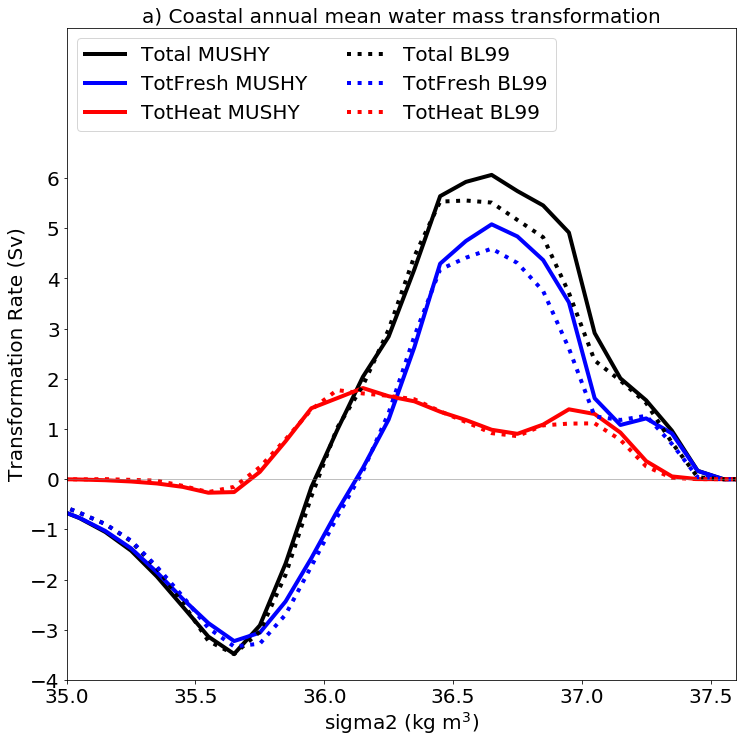

In [26]:
#Plot transformations averaged over all time
f=plt.figure(figsize=(12,12))
plt.plot(wmt1_ann.sigma,wmt1_ann/1e6,label="Total "+label1,color='black',linestyle='-', linewidth=4)
plt.plot(wmt1_fresh_ann.sigma,wmt1_fresh_ann/1e6,label="TotFresh "+label1,color='blue',linestyle='-', linewidth=4)
plt.plot(wmt1_heat_ann.sigma,wmt1_heat_ann/1e6,label="TotHeat "+label1,color='red',linestyle='-', linewidth=4)
plt.plot(wmt2_ann.sigma,wmt2_ann/1e6,label="Total "+label2,color='black',linestyle=':', linewidth=4)
plt.plot(wmt2_fresh_ann.sigma,wmt2_fresh_ann/1e6,label="TotFresh "+label2,color='blue',linestyle=':', linewidth=4)
plt.plot(wmt2_heat_ann.sigma,wmt2_heat_ann/1e6,label="TotHeat "+label2,color='red',linestyle=':', linewidth=4)
plt.title('a) Coastal annual mean water mass transformation',fontsize=20)
plt.xlabel('sigma2 (kg m$^3$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Transformation Rate (Sv)',fontsize=20)
plt.yticks(np.arange(-4, 7, 1),fontsize=20)
plt.ylim([-4,9])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend(loc=2,ncol=2,fontsize=20)
#plt.savefig('coastal_WMT_'+label1+'_and_'+label2+'_sigma2.png', bbox_inches='tight', dpi=200)

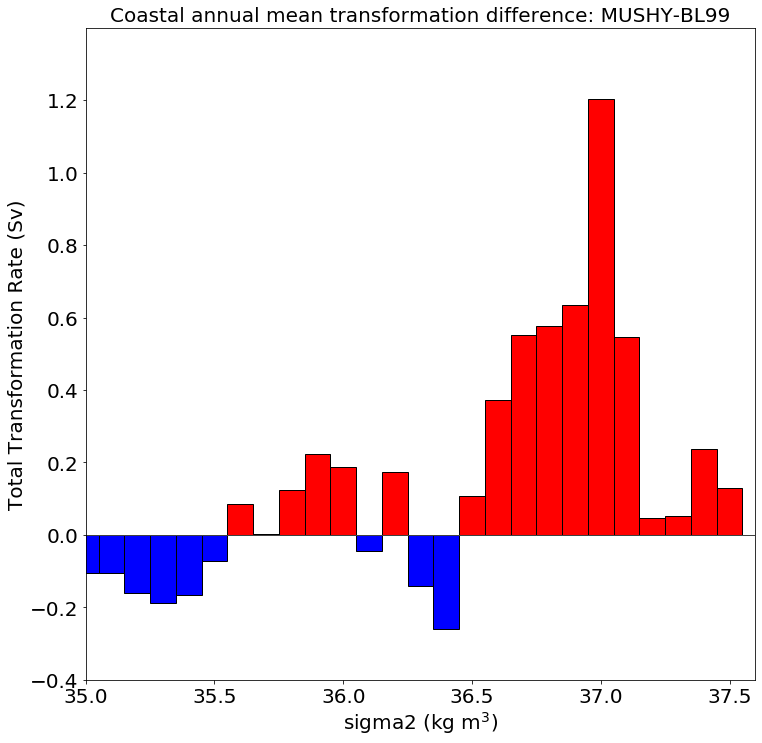

In [27]:
colors = ['red' if (value > 0) else 'blue' for value in wmt_ann_diff]

f=plt.figure(figsize=(12,12))
plt.bar(wmt_ann_diff.sigma,wmt_ann_diff/1e6,align='edge',edgecolor='black',color=colors,width=0.1)
plt.title('Coastal annual mean transformation difference: '+label1+'-'+label2,fontsize=20)
plt.xlabel('sigma2 (kg m$^3$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Transformation Rate (Sv)',fontsize=20)
plt.yticks(np.arange(-0.4, 1.4, 0.2),fontsize=20)
plt.ylim([-0.4,1.4])
plt.ylabel('Total Transformation Rate (Sv)',fontsize=20)
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
#plt.savefig('coastal_WMT_diff_'+label1+'_minus_'+label2+'_sigma2.png', bbox_inches='tight', dpi=200)

Plots of the **transformation** freshwater components

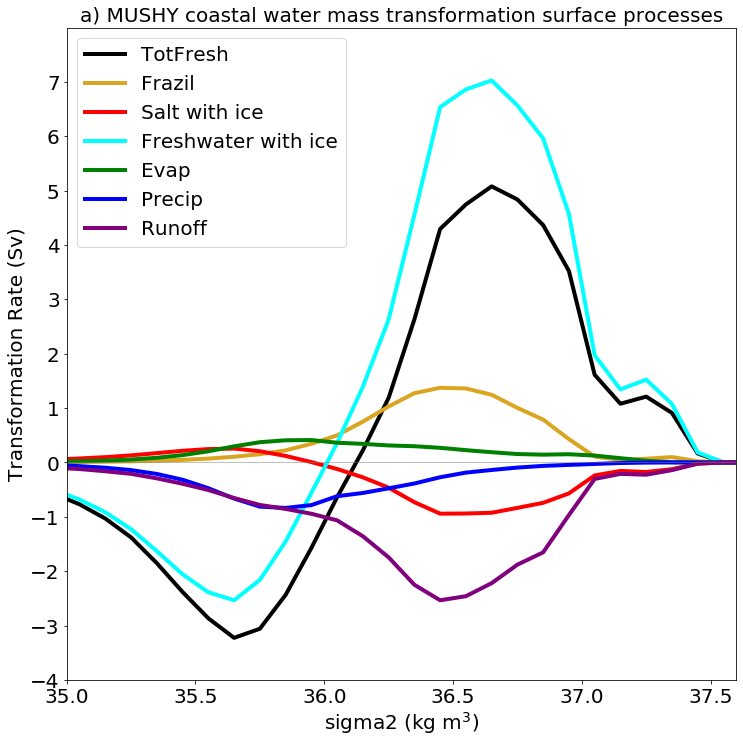

In [28]:
#Plot transformation components averaged over all time
f=plt.figure(figsize=(12,12))
plt.plot(wmt1_fresh_ann.sigma,wmt1_fresh_ann/1e6,label="TotFresh",color='black',linestyle='-', linewidth=4)
#plt.plot(wmt1_recons_ann.sigma,wmt1_recons_ann/1e6,label="Recons",color='grey',linestyle='-', linewidth=4)
plt.plot(wmt1_frazil_ann.sigma,wmt1_frazil_ann/1e6,label="Frazil",color='goldenrod',linestyle='-', linewidth=4)
plt.plot(wmt1_salt_ann.sigma,wmt1_salt_ann/1e6,label="Salt with ice",color='red',linestyle='-', linewidth=4)
plt.plot(wmt1_melt_ann.sigma,wmt1_melt_ann/1e6,label="Freshwater with ice",color='cyan',linestyle='-', linewidth=4)
plt.plot(wmt1_evap_ann.sigma,wmt1_evap_ann/1e6,label="Evap",color='green',linestyle='-', linewidth=4)
plt.plot(wmt1_precip_ann.sigma,wmt1_precip_ann/1e6,label="Precip",color='blue',linestyle='-', linewidth=4)
plt.plot(wmt1_runoff_ann.sigma,wmt1_runoff_ann/1e6,label="Runoff",color='purple',linestyle='-', linewidth=4)

plt.title('a) '+label1+' coastal water mass transformation surface processes',fontsize=20)
plt.xlabel('sigma2 (kg m$^3$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Transformation Rate (Sv)',fontsize=20)
plt.yticks(np.arange(-4, 8, 1),fontsize=20)
plt.ylim([-4,8])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend(loc=2,ncol=1,fontsize=20)
#plt.savefig('coastal_WMT_fresh_components_'+label1+'_sigma2.png', bbox_inches='tight', dpi=200)

<Figure size 864x864 with 0 Axes>

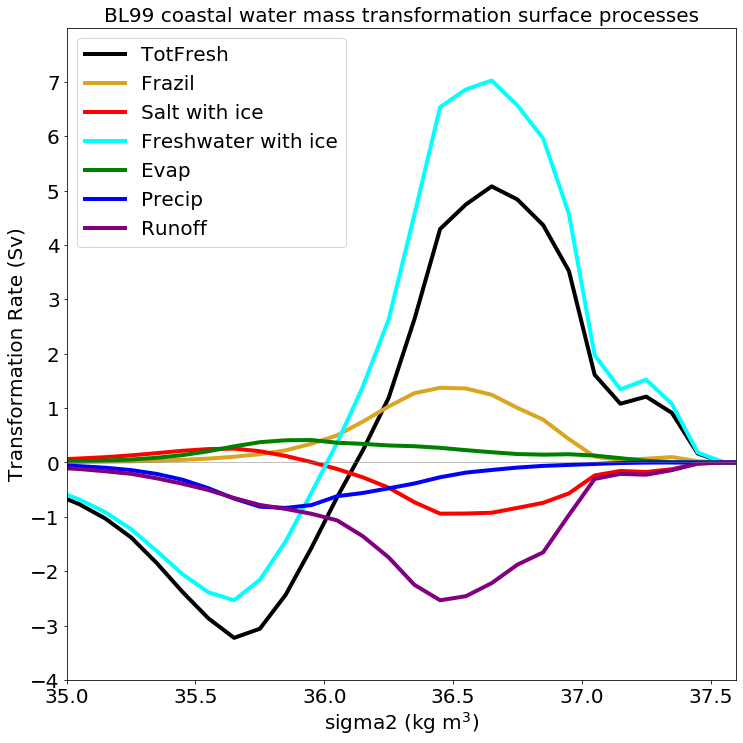

In [29]:
#Plot transformation components averaged over all time
f=plt.figure(figsize=(12,12))
f=plt.figure(figsize=(12,12))
plt.plot(wmt2_fresh_ann.sigma,wmt1_fresh_ann/1e6,label="TotFresh",color='black',linestyle='-', linewidth=4)
#plt.plot(wmt2_recons_ann.sigma,wmt1_recons_ann/1e6,label="Recons",color='grey',linestyle='-', linewidth=4)
plt.plot(wmt2_frazil_ann.sigma,wmt1_frazil_ann/1e6,label="Frazil",color='goldenrod',linestyle='-', linewidth=4)
plt.plot(wmt2_salt_ann.sigma,wmt1_salt_ann/1e6,label="Salt with ice",color='red',linestyle='-', linewidth=4)
plt.plot(wmt2_melt_ann.sigma,wmt1_melt_ann/1e6,label="Freshwater with ice",color='cyan',linestyle='-', linewidth=4)
plt.plot(wmt2_evap_ann.sigma,wmt1_evap_ann/1e6,label="Evap",color='green',linestyle='-', linewidth=4)
plt.plot(wmt2_precip_ann.sigma,wmt1_precip_ann/1e6,label="Precip",color='blue',linestyle='-', linewidth=4)
plt.plot(wmt2_runoff_ann.sigma,wmt1_runoff_ann/1e6,label="Runoff",color='purple',linestyle='-', linewidth=4)

plt.title(label2+' coastal water mass transformation surface processes',fontsize=20)
plt.xlabel('sigma2 (kg m$^3$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Transformation Rate (Sv)',fontsize=20)
plt.yticks(np.arange(-4, 8, 1),fontsize=20)
plt.ylim([-4,8])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend(loc=2,ncol=1,fontsize=20)
#plt.savefig('coastal_WMT_fresh_components_'+label2+'_sigma2.png', bbox_inches='tight', dpi=200)

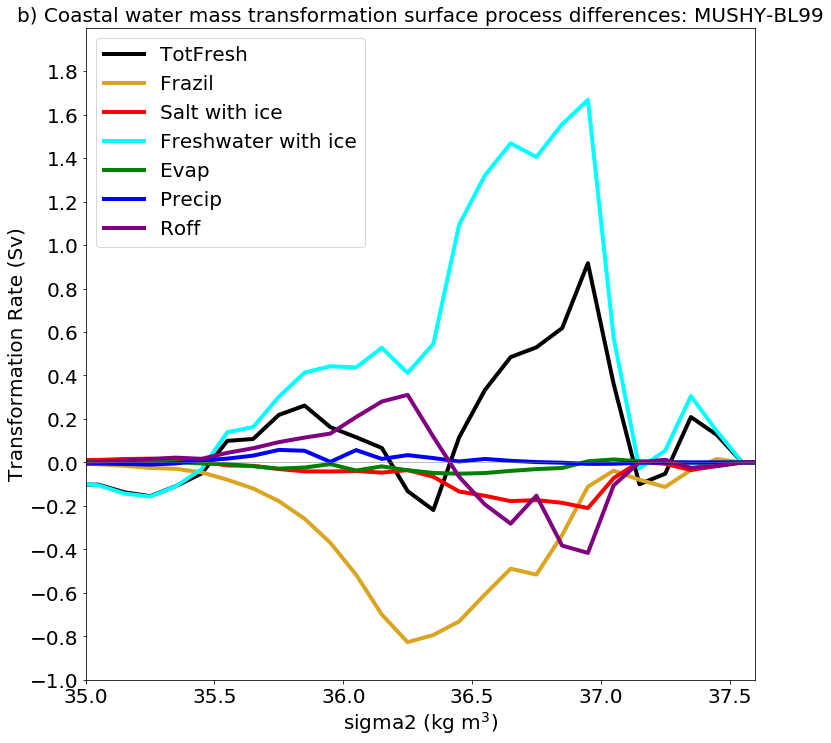

In [30]:
#Plot transformation components averaged over all time; MUSHY - BL99
f=plt.figure(figsize=(12,12))
plt.plot(wmt2_fresh_ann.sigma,(wmt1_fresh_ann-wmt2_fresh_ann)/1e6,label="TotFresh",color='black',linestyle='-', linewidth=4)
#plt.plot(wmt2_recons_ann.sigma,(wmt1_recons_ann-wmt2_recons_ann)/1e6 ,label="Recons",color='grey',linestyle='-', linewidth=4)
plt.plot(wmt2_frazil_ann.sigma,(wmt1_frazil_ann-wmt2_frazil_ann)/1e6,label="Frazil",color='goldenrod',linestyle='-', linewidth=4)
plt.plot(wmt2_salt_ann.sigma,(wmt1_salt_ann-wmt2_salt_ann)/1e6,label="Salt with ice",color='red',linestyle='-', linewidth=4)
plt.plot(wmt2_melt_ann.sigma,(wmt1_melt_ann-wmt2_melt_ann)/1e6,label="Freshwater with ice",color='cyan',linestyle='-', linewidth=4)
plt.plot(wmt2_evap_ann.sigma,(wmt1_evap_ann-wmt2_evap_ann)/1e6,label="Evap",color='green',linestyle='-', linewidth=4)
plt.plot(wmt2_precip_ann.sigma,(wmt1_precip_ann-wmt2_precip_ann)/1e6,label="Precip",color='blue',linestyle='-', linewidth=4)
plt.plot(wmt2_runoff_ann.sigma,(wmt1_runoff_ann-wmt2_runoff_ann)/1e6,label="Roff",color='purple',linestyle='-', linewidth=4)

plt.title('b) Coastal water mass transformation surface process differences: '+label1+'-'+label2,fontsize=20)
plt.xlabel('sigma2 (kg m$^3$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Transformation Rate (Sv)',fontsize=20)
plt.yticks(np.arange(-1, 2, 0.2),fontsize=20)
plt.ylim([-1,2])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend(loc=2,ncol=1,fontsize=20)
#plt.savefig('coastal_WMT_fresh_components_diff_'+label1+'-'+label2+'.png', bbox_inches='tight', dpi=200)

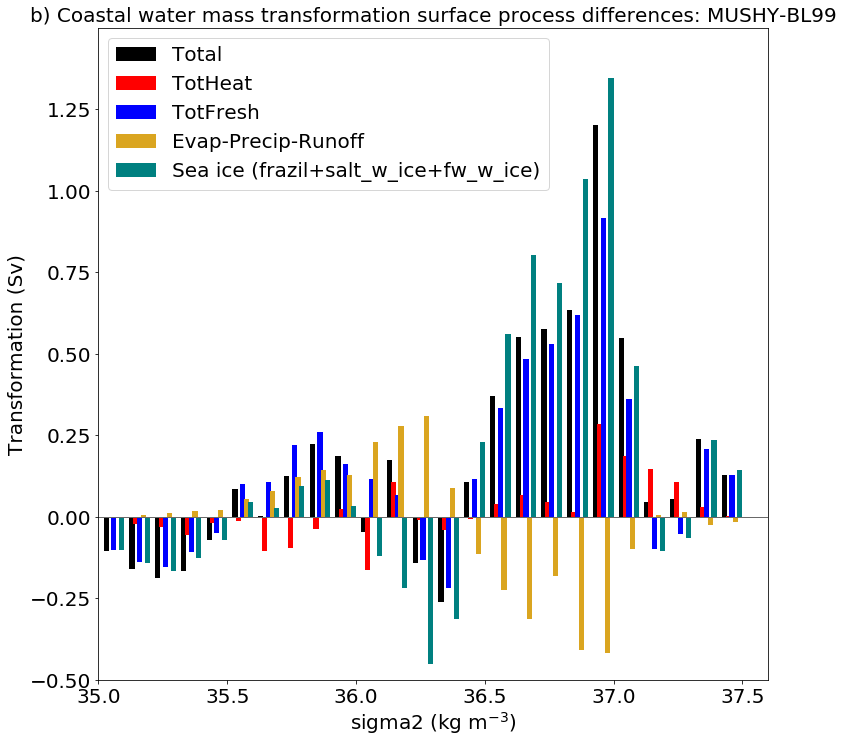

In [31]:
#transformation by processes: 
#Total
#all heating
#E-P-R
#Sea ice related stuff: Frazil+Brine+Melt

f=plt.figure(figsize=(12,12))

things_to_plot ={}
things_to_plot['Total'] = wmt_ann_diff
things_to_plot['TotHeat'] = wmt_heat_ann_diff
things_to_plot['TotFresh'] = wmt_fresh_ann_diff
things_to_plot['Evap-Precip-Runoff'] = wmt_epr_ann_diff
things_to_plot['Sea ice (frazil+salt_w_ice+fw_w_ice)'] = wmt_ice_ann_diff

colors=['black','red','blue','goldenrod','teal']

for ii,key in enumerate(things_to_plot.keys()):
    plot_me = things_to_plot[key]
    plt.bar(plot_me.sigma+0.015*(ii-2),plot_me/1e6,align='edge',edgecolor='None',\
            color=colors[ii], width=0.02,label = key)
    
plt.legend(loc=2,fontsize=20)
plt.xlabel('sigma2 (kg m$^{-3}$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Transformation (Sv)',fontsize=20)
plt.yticks(np.arange(-0.5, 1.5, 0.25),fontsize=20)
plt.ylim([-0.5,1.5])
plt.title('b) Coastal water mass transformation surface process differences: '+label1+'-'+label2 ,fontsize=20)
plt.axhline(0,color='dimgray',linewidth=1)
#plt.savefig('coastal_WMT_processes_diff_'+label1+'-'+label2+'.png', bbox_inches='tight', dpi=200)

### Formation Plots

Plots of the **formation** for total and total heat and total freshwater components

In [ ]:
#Plot formation averaged over all time
f=plt.figure(figsize=(12,12))
plt.plot(wmf1_ann.sigma,wmf1_ann/1e6,label="Total "+label1,color='black',linestyle='-', linewidth=4)
plt.plot(wmf1_fresh_ann.sigma,wmf1_fresh_ann/1e6,label="TotFresh "+label1,color='blue',linestyle='-', linewidth=4)
plt.plot(wmf1_heat_ann.sigma,wmf1_heat_ann/1e6,label="TotHeat "+label1,color='red',linestyle='-', linewidth=4)
plt.plot(wmf2_ann.sigma,wmf2_ann/1e6,label="Total "+label2,color='black',linestyle=':', linewidth=4)
plt.plot(wmf2_fresh_ann.sigma,wmf2_fresh_ann/1e6,label="TotFresh "+label2,color='blue',linestyle=':', linewidth=4)
plt.plot(wmf2_heat_ann.sigma,wmf2_heat_ann/1e6,label="TotHeat "+label2,color='red',linestyle=':', linewidth=4)

plt.title('Coastal annual mean water mass formation',fontsize=20)
plt.xlabel('sigma2 (kg m$^3$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Formation Rate (Sv)',fontsize=20)
plt.yticks(np.arange(-4, 7, 1),fontsize=20)
plt.ylabel('Formation Rate (Sv)',fontsize=20)
plt.ylim([-2,3])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=36.6, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=37.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend(loc=2,ncol=2,fontsize=20)
plt.savefig('coastal_WMF_'+label1+'_and_'+label2+'_sigma2.png', bbox_inches='tight', dpi=200)

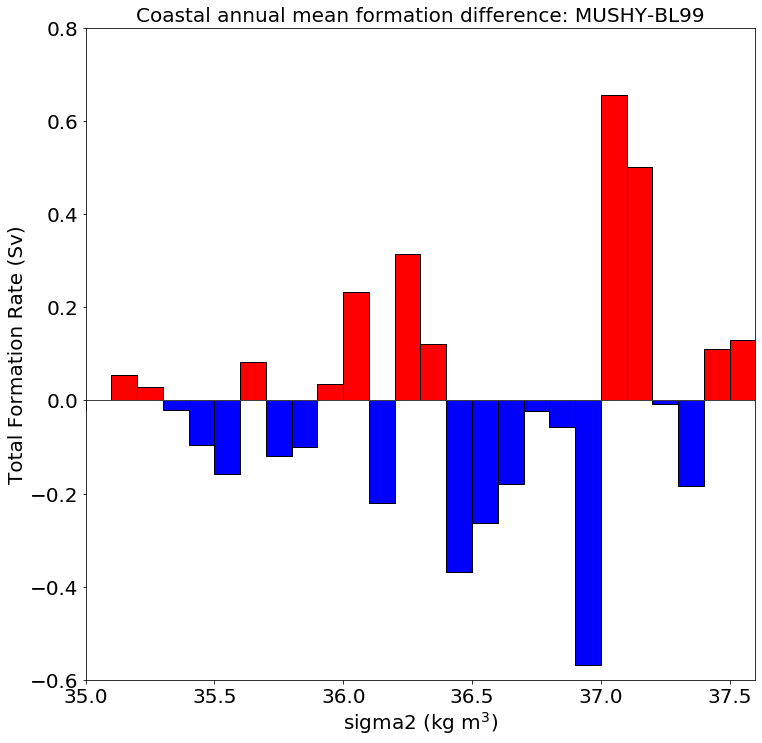

In [39]:
colors = ['red' if (value > 0) else 'blue' for value in wmf_ann_diff]

f=plt.figure(figsize=(12,12))
plt.bar(wmf_ann_diff.sigma,wmf_ann_diff/1e6,align='edge',edgecolor='black',color=colors,width=0.1)
plt.title('Coastal annual mean formation difference: '+label1+'-'+label2,fontsize=20)
plt.xlabel('sigma2 (kg m$^3$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Formation Rate (Sv)',fontsize=20)
plt.yticks(np.arange(-0.8, 1.4, 0.2),fontsize=20)
plt.ylim([-0.6,0.8])
plt.ylabel('Total Formation Rate (Sv)',fontsize=20)
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
#plt.savefig('coastal_WMF_diff_'+label1+'_minus_'+label2+'_sigma2.png', bbox_inches='tight', dpi=200)

Plots of the **formation** freshwater components

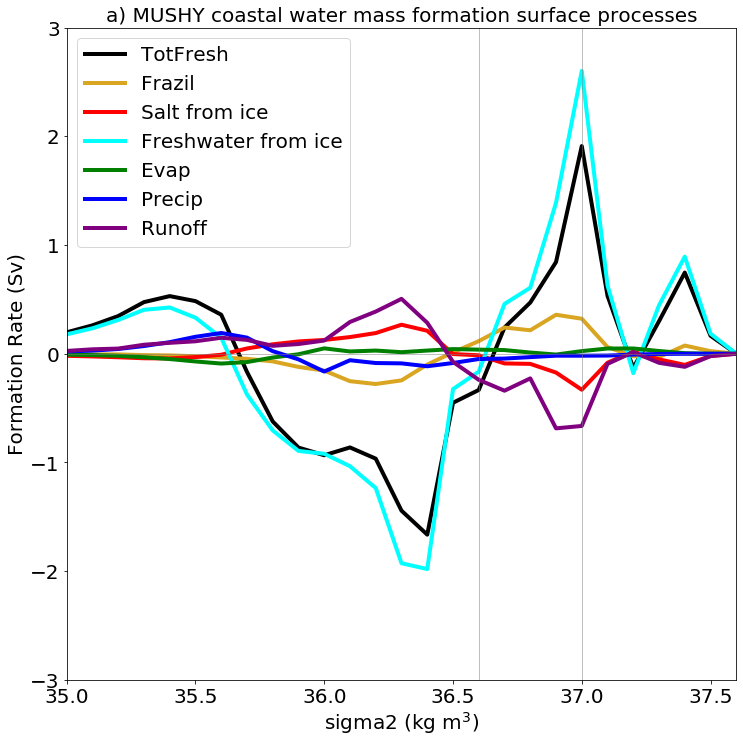

In [34]:
#Plot formation components averaged over all time
f=plt.figure(figsize=(12,12))
plt.plot(wmf1_fresh_ann.sigma,wmf1_fresh_ann/1e6,label="TotFresh",color='black',linestyle='-', linewidth=4)
#plt.plot(wmf1_recons_ann.sigma,wmf1_recons_ann/1e6,label="Recons",color='grey',linestyle='-', linewidth=4)
plt.plot(wmf1_frazil_ann.sigma,wmf1_frazil_ann/1e6,label="Frazil",color='goldenrod',linestyle='-', linewidth=4)
plt.plot(wmf1_salt_ann.sigma,wmf1_salt_ann/1e6,label="Salt from ice",color='red',linestyle='-', linewidth=4)
plt.plot(wmf1_melt_ann.sigma,wmf1_melt_ann/1e6,label="Freshwater from ice",color='cyan',linestyle='-', linewidth=4)
plt.plot(wmf1_evap_ann.sigma,wmf1_evap_ann/1e6,label="Evap",color='green',linestyle='-', linewidth=4)
plt.plot(wmf1_precip_ann.sigma,wmf1_precip_ann/1e6,label="Precip",color='blue',linestyle='-', linewidth=4)
plt.plot(wmf1_runoff_ann.sigma,wmf1_runoff_ann/1e6,label="Runoff",color='purple',linestyle='-', linewidth=4)

plt.title('a) '+label1+' coastal water mass formation surface processes',fontsize=20)
plt.xlabel('sigma2 (kg m$^3$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Formation Rate (Sv)',fontsize=20)
plt.yticks(np.arange(-4, 8, 1),fontsize=20)
plt.ylim([-3,3])
plt.axvline(x=36.6, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=37.0, color='grey', linestyle='-', linewidth=0.5)
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend(loc=2,ncol=1,fontsize=20)
plt.savefig('coastal_WMF_fresh_components_'+label1+'_sigma2.png', bbox_inches='tight', dpi=200)

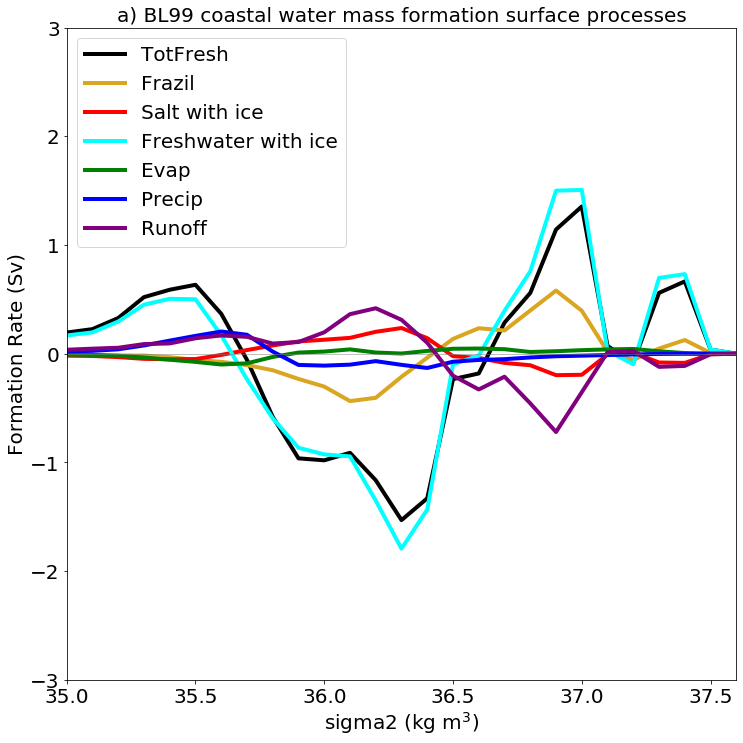

In [35]:
#Plot formation components averaged over all time
f=plt.figure(figsize=(12,12))
plt.plot(wmf2_fresh_ann.sigma,wmf2_fresh_ann/1e6,label="TotFresh",color='black',linestyle='-', linewidth=4)
#plt.plot(wmf2_recons_ann.sigma,wmf2_recons_ann/1e6,label="Recons",color='grey',linestyle='-', linewidth=4)
plt.plot(wmf2_frazil_ann.sigma,wmf2_frazil_ann/1e6,label="Frazil",color='goldenrod',linestyle='-', linewidth=4)
plt.plot(wmf2_salt_ann.sigma,wmf2_salt_ann/1e6,label="Salt with ice",color='red',linestyle='-', linewidth=4)
plt.plot(wmf2_melt_ann.sigma,wmf2_melt_ann/1e6,label="Freshwater with ice",color='cyan',linestyle='-', linewidth=4)
plt.plot(wmf2_evap_ann.sigma,wmf2_evap_ann/1e6,label="Evap",color='green',linestyle='-', linewidth=4)
plt.plot(wmf2_precip_ann.sigma,wmf2_precip_ann/1e6,label="Precip",color='blue',linestyle='-', linewidth=4)
plt.plot(wmf2_runoff_ann.sigma,wmf2_runoff_ann/1e6,label="Runoff",color='purple',linestyle='-', linewidth=4)

plt.title('a) '+label2+' coastal water mass formation surface processes',fontsize=20)
plt.xlabel('sigma2 (kg m$^3$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Formation Rate (Sv)',fontsize=20)
plt.yticks(np.arange(-4, 8, 1),fontsize=20)
plt.ylim([-3,3])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend(loc=2,ncol=1,fontsize=20)
#plt.savefig('coastal_WMF_fresh_components_'+label2+'_sigma2.png', bbox_inches='tight', dpi=200)

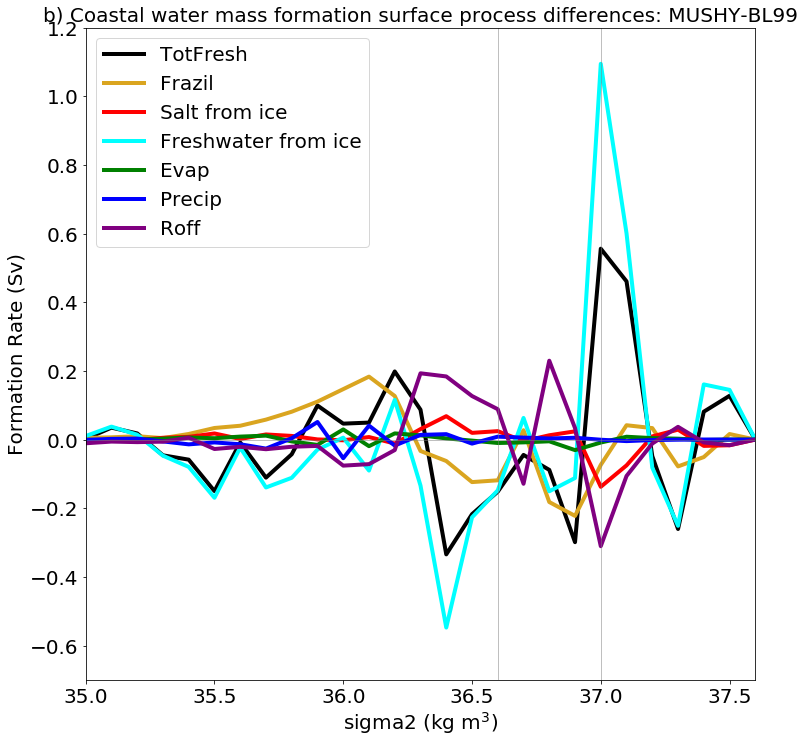

In [36]:
#Plot formation components averaged over all time; MUSHY - BL99
f=plt.figure(figsize=(12,12))
plt.plot(wmf2_fresh_ann.sigma,(wmf1_fresh_ann-wmf2_fresh_ann)/1e6,label="TotFresh",color='black',linestyle='-', linewidth=4)
#plt.plot(wmf2_recons_ann.sigma,(wmf1_recons_ann-wmf2_recons_ann)/1e6 ,label="Recons",color='grey',linestyle='-', linewidth=4)
plt.plot(wmf2_frazil_ann.sigma,(wmf1_frazil_ann-wmf2_frazil_ann)/1e6,label="Frazil",color='goldenrod',linestyle='-', linewidth=4)
plt.plot(wmf2_salt_ann.sigma,(wmf1_salt_ann-wmf2_salt_ann)/1e6,label="Salt from ice",color='red',linestyle='-', linewidth=4)
plt.plot(wmf2_melt_ann.sigma,(wmf1_melt_ann-wmf2_melt_ann)/1e6,label="Freshwater from ice",color='cyan',linestyle='-', linewidth=4)
plt.plot(wmf2_evap_ann.sigma,(wmf1_evap_ann-wmf2_evap_ann)/1e6,label="Evap",color='green',linestyle='-', linewidth=4)
plt.plot(wmf2_precip_ann.sigma,(wmf1_precip_ann-wmf2_precip_ann)/1e6,label="Precip",color='blue',linestyle='-', linewidth=4)
plt.plot(wmf2_runoff_ann.sigma,(wmf1_runoff_ann-wmf2_runoff_ann)/1e6,label="Roff",color='purple',linestyle='-', linewidth=4)

plt.title('b) Coastal water mass formation surface process differences: '+label1+'-'+label2,fontsize=20)
plt.xlabel('sigma2 (kg m$^3$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Formation Rate (Sv)',fontsize=20)
plt.yticks(np.arange(-1, 2, 0.2),fontsize=20)
plt.ylim([-0.7,1.2])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=36.6, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=37.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend(loc=2,ncol=1,fontsize=20)
plt.savefig('coastal_WMF_fresh_components_diff_'+label1+'-'+label2+'.png', bbox_inches='tight', dpi=200)

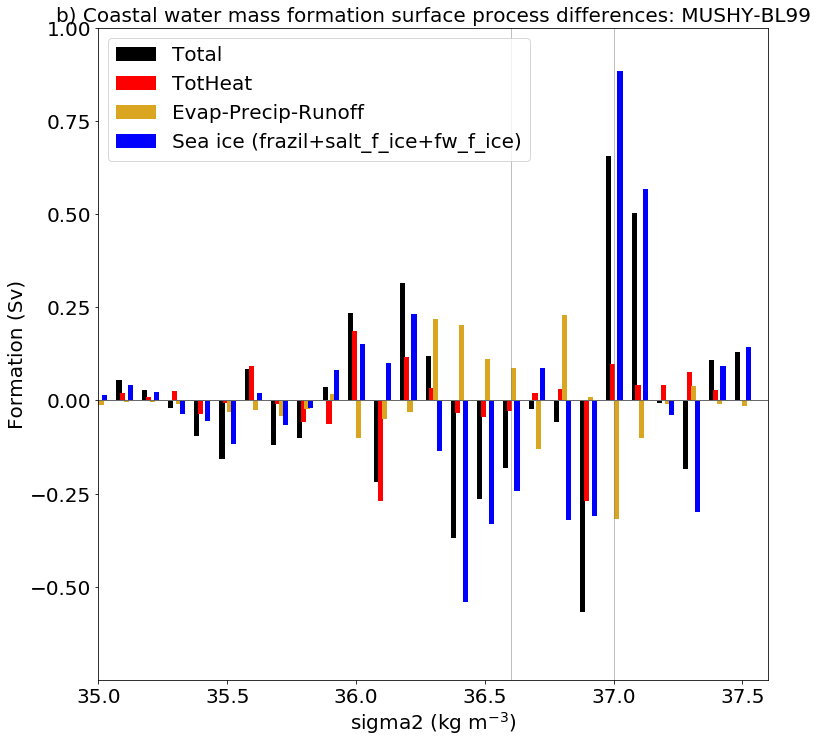

In [37]:
#transformation by processes: 
#Total
#all heating
#E-P-R
#Sea ice related stuff: Frazil+Brine+Melt

f=plt.figure(figsize=(12,12))

things_to_plot ={}
things_to_plot['Total'] = wmf_ann_diff
things_to_plot['TotHeat'] = wmf_heat_ann_diff
#things_to_plot['TotFresh'] = wmf_fresh_ann_diff
things_to_plot['Evap-Precip-Runoff'] = wmf_epr_ann_diff
things_to_plot['Sea ice (frazil+salt_f_ice+fw_f_ice)'] = wmf_ice_ann_diff

#colors=['black','red','blue','goldenrod','teal']
colors=['black','red','goldenrod','blue']

for ii,key in enumerate(things_to_plot.keys()):
    plot_me = things_to_plot[key]
    plt.bar(plot_me.sigma+0.015*(ii-2),plot_me/1e6,align='edge',edgecolor='None',\
            color=colors[ii], width=0.02,label = key)
    
plt.legend(loc=2,fontsize=20)
plt.xlabel('sigma2 (kg m$^{-3}$)',fontsize=20)
plt.xticks(np.arange(35.0, 38, 0.5),fontsize=20)
plt.xlim([35,37.6])
plt.ylabel('Formation (Sv)',fontsize=20)
plt.yticks(np.arange(-0.5, 1.5, 0.25),fontsize=20)
plt.ylim([-0.75,1.0])
plt.title('b) Coastal water mass formation surface process differences: '+label1+'-'+label2 ,fontsize=20)
plt.axhline(0,color='dimgray',linewidth=1)
plt.axvline(x=36.6, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=37.0, color='grey', linestyle='-', linewidth=0.5)
plt.savefig('coastal_WMF_processes_diff_'+label1+'-'+label2+'.png', bbox_inches='tight', dpi=200)

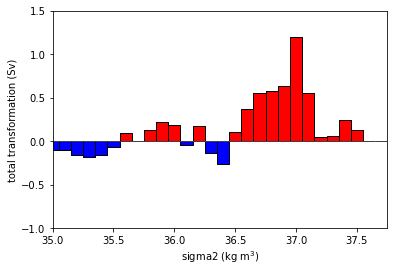

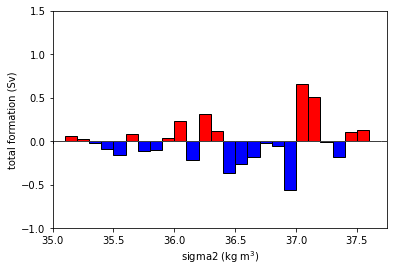

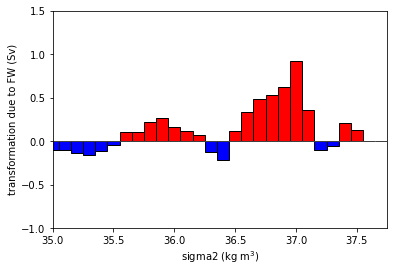

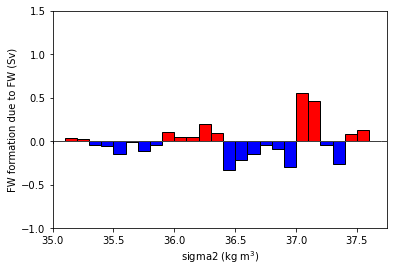

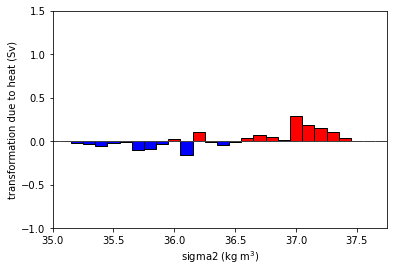

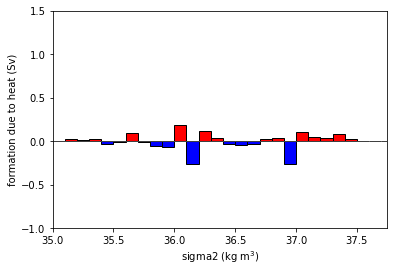

In [38]:
# Plot differences in transformation/formation due to FReshwater and heat so we can attribute differences at different
# density categories
things_to_plot={}
things_to_plot['total transformation']=wmt_ann_diff
things_to_plot['total formation']=wmf_ann_diff
things_to_plot['transformation due to FW']=wmt_fresh_ann_diff
things_to_plot['FW formation due to FW']=wmf_fresh_ann_diff
things_to_plot['transformation due to heat']=wmt_heat_ann_diff
things_to_plot['formation due to heat']=wmf_heat_ann_diff

for wm in things_to_plot.keys():

    plot_me = things_to_plot[wm]
    colors = ['red' if (value > 0) else 'blue' for value in plot_me]

    f=plt.figure()
    
    plt.bar(plot_me.sigma,plot_me/1e6,align='edge',edgecolor='black',color=colors,width=0.1)
    #plt.title('Annual mean water mass transformation difference: '+label1+'-'+label2)
    plt.xlabel('sigma2 (kg m$^3$)')
    plt.xlim([35,37.75])
    plt.ylabel(wm+' (Sv)')
    plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
    plt.axvline(x=27.0, color='grey', linestyle='-',linewidth=0.5)
    plt.axvline(x=27.5, color='grey', linestyle='-',linewidth=0.5)
    plt.axvline(x=28.0, color='grey', linestyle='-',linewidth=0.5)
    plt.axvline(x=28.2, color='grey', linestyle='-',linewidth=0.5)
    plt.ylim([-1,1.5])
